In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from utils.losses import heatmap_mse_loss
from utils.pckh import compute_pckh
from utils.heatmaps import heatmaps_to_coords
from utils.visualisations import visualize_batch_predictions
from data.mpii_dataset import MPIIDataset
from models.model import ViTPoseHeatmap, ViTPoseHeatmapBatchnorm

/Users/kayden/anaconda3/envs/capstone_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


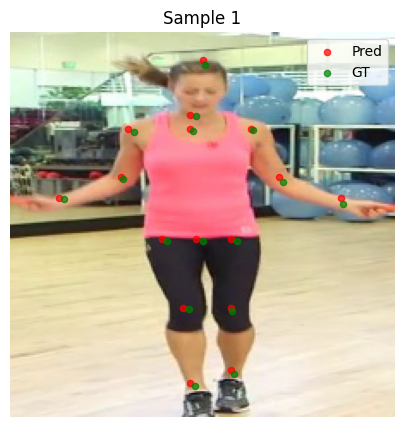

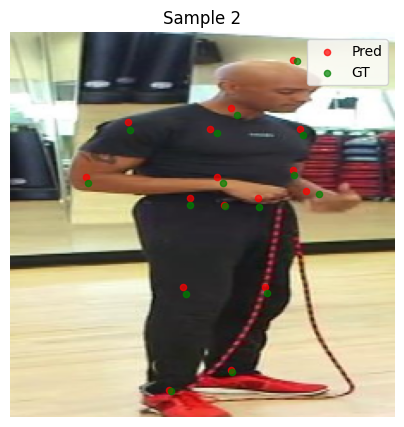

In [ ]:
def infer(model, test_loader, device='cuda', img_size=224, state_dict_url="best_model.pth"):
    # Load checkpoint
    state_dict = torch.hub.load_state_dict_from_url(state_dict_url, map_location=torch.device('cpu'))

    # 🔧 Auto-handle DataParallel "module." prefixes
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        new_state_dict[k.replace("module.", "")] = v

    model = model.to(device)
    model.load_state_dict(new_state_dict, strict=False)
    model.eval()


    with torch.no_grad():
        for batch in test_loader:
            imgs = batch['image'].to(device)
            hmaps = batch['heatmaps'].to(device)
            joints = batch['joints'].to(device)
            vis = batch['visibility'].to(device)

            pred = model(imgs)


            # decode coords
            coords = heatmaps_to_coords(pred)


    # visualize a few predictions
    visualize_batch_predictions(model, test_loader, device=device, img_size=img_size, n_samples=2)


device = "cuda" if torch.cuda.is_available() else "cpu"

model = ViTPoseHeatmap(vit_name="vit_small_patch16_224")

model = model.to(device)

test_dataset = MPIIDataset('sample_images/sample_annotations.json', 'sample_images/')
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=1)

infer(model, test_loader, device=device, img_size=224, state_dict_url='https://huggingface.co/shai-hulud/AIML339Capstone/resolve/main/vit_small_30e_newmse_rateschedulerdecay_5e-4.pth')
